## Dataset initialization

In [1]:
import pandas as pd

#import data sets in meth data
df0=pd.read_csv('KIRC_HumanMethylation450.data',sep='\t').set_index('sample').T
df1=pd.read_csv('KIRP_HumanMethylation450.data',sep='\t').set_index('sample').T
df2=pd.read_csv('KICH_HumanMethylation450.data',sep='\t').set_index('sample').T

In [2]:
df0.shape, df1.shape, df2.shape

((480, 485578), (321, 485578), (66, 485578))

## Preprocessing

### 1. Data Integration

In [3]:
df=pd.concat([df0, df1, df2])

In [4]:
df.shape

(867, 485578)


### 2. Data Cleaning

In [6]:
df.isnull().sum()

sample
cg13332474    0
cg00651829    0
cg17027195    0
cg09868354    0
cg03050183    2
             ..
cg10230711    0
cg16651827    0
cg18138552    0
cg07883722    0
Subtype       0
Length: 485578, dtype: int64

In [7]:
# Count the null values containing features
n=(df.isnull().sum()>0).sum()
n

110192

In [8]:
# Check the null values
df.isnull().sum().sort_values(ascending = False).head(n)

sample
cg20383654    867
cg01757760    867
cg23688350    867
cg24536120    867
cg01763947    867
             ... 
cg14467794      1
cg17784749      1
cg21821726      1
cg14872074      1
cg12753851      1
Length: 110192, dtype: int64

In [9]:
# drop the null values
df=df.dropna(axis=1)

In [10]:
df.shape

(867, 375386)

In [11]:
print('Count of zeros')
for column_name in df.columns:
    column = df[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    if(count>0):
        print('\t', column_name, ' : ', count)

Count of zeros
	 Subtype  :  480


### 3. Dataset balancing

In [12]:
df['Subtype'].value_counts()

0.0    480
1.0    321
2.0     66
Name: Subtype, dtype: int64

- Dataset is unbalance

#### Oversampling amd undersampling

In [13]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Resampling the minority class.
ros = RandomOverSampler(sampling_strategy={2: 100}, random_state=42)

# Resampling the majority classes.
rus = RandomUnderSampler(sampling_strategy={0: 100,1:100}, random_state=42)

In [14]:
Y=df['Subtype']

In [15]:
x=df.drop(['Subtype'], axis=1)

In [16]:
# Fit the model to generate the data with all features dataset
oversampled_X, oversampled_Y = ros.fit_resample(x, Y) 
sampled_X, sampled_Y = rus.fit_resample(oversampled_X, oversampled_Y)

### 5. Feature Scaling

In [18]:
sampled_X.min(axis=0)

sample
cg13332474    0.0175
cg00651829    0.0116
cg17027195    0.0199
cg09868354    0.0333
cg06819656    0.4675
               ...  
cg11692435    0.4168
cg10230711    0.0300
cg16651827    0.2425
cg18138552    0.0125
cg07883722    0.6096
Length: 375385, dtype: float64

In [19]:
sampled_X.max(axis=0)

sample
cg13332474    0.7825
cg00651829    0.6681
cg17027195    0.5537
cg09868354    0.2145
cg06819656    0.9594
               ...  
cg11692435    0.9917
cg10230711    0.9709
cg16651827    0.8580
cg18138552    0.3392
cg07883722    0.9684
Length: 375385, dtype: float64

## Test SVM model

In [20]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

#### Check the kernels in SVM 

In [21]:
acc = cross_val_score(svm.SVC(random_state=0), sampled_X, sampled_Y, cv=5)
print("Accuracy SVM with rbf kernel: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))

Accuracy SVM with rbf kernel: 0.87 (+/- 0.11)


In [52]:
acc = cross_val_score(svm.SVC(kernel='poly',random_state=0), sampled_X, sampled_Y, cv=5)
print("Accuracy SVM with poly kernel: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))

Accuracy SVM with poly kernel: 0.92 (+/- 0.07)


In [22]:
acc = cross_val_score(svm.SVC(kernel='linear',random_state=0), sampled_X, sampled_Y, cv=5)
print("Accuracy SVM with linear kernel: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))

Accuracy SVM with linear kernel: 0.96 (+/- 0.06)


In [54]:
acc = cross_val_score(svm.SVC(kernel='sigmoid',random_state=0), sampled_X, sampled_Y, cv=5)
print("Accuracy SVM with sigmoid kernel: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))

Accuracy SVM with sigmoid kernel: 0.65 (+/- 0.06)


- linear performed well

#### Check the feature scaling method to SVM

In [23]:
svc=svm.SVC(kernel='linear',random_state=0)

In [24]:
acc = cross_val_score(svc, sampled_X, sampled_Y, cv=5)
print("Accuracy SVM without transformation: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))

Accuracy SVM without transformation: 0.96 (+/- 0.06)


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [29]:
# create pipeline -> Standardization
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                   ('model',svc)])

# perform cross validation
acc = cross_val_score(estimator=pipeline, 
                         X=sampled_X, 
                         y=sampled_Y, 
                         cv=5
                        )

print("Accuracy SVM with Standardization: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))

Accuracy SVM with Standardization: 0.96 (+/- 0.06)


In [27]:
# create pipeline - > Normalizaton
pipeline = Pipeline(steps=[('scaler', preprocessing.MinMaxScaler()),
                   ('model', svc)])

# perform cross validation
acc = cross_val_score(estimator=pipeline, 
                         X=sampled_X, 
                         y=sampled_Y, 
                         cv=5
                        )

print("Accuracy SVM with Normalizaton: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))

Accuracy SVM with Normalizaton: 0.96 (+/- 0.07)


## Test RF model

In [60]:
from sklearn.ensemble import RandomForestClassifier

# RF Parameter optimization

In [61]:
rfc = RandomForestClassifier()

In [62]:
parameters = {
    "n_estimators":[100,500,1000],
    "max_depth":[4,8,16,None],
    "criterion":['gini', 'entropy'],
    "random_state": [0]
}

In [63]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rfc,parameters,cv=5)
cv.fit(sampled_X,sampled_Y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 16, None],
                         'n_estimators': [100, 500, 1000],
                         'random_state': [0]})

In [64]:
print(f'Best parameters are: {cv.best_params_}')

Best parameters are: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 500, 'random_state': 0}


In [70]:
rf=RandomForestClassifier(criterion= 'entropy', max_depth= 8, n_estimators= 500,random_state= 0)

In [71]:
acc = cross_val_score(rf, sampled_X, sampled_Y, cv=5)
print("Accuracy RF with best_params: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))

Accuracy RF with best_params: 0.95 (+/- 0.04)


## Test KNN model

In [72]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

#### Find the best k value for KNN 

/home/eng2018e102/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/eng2018e102/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

Text(0, 0.5, 'Accuracy')

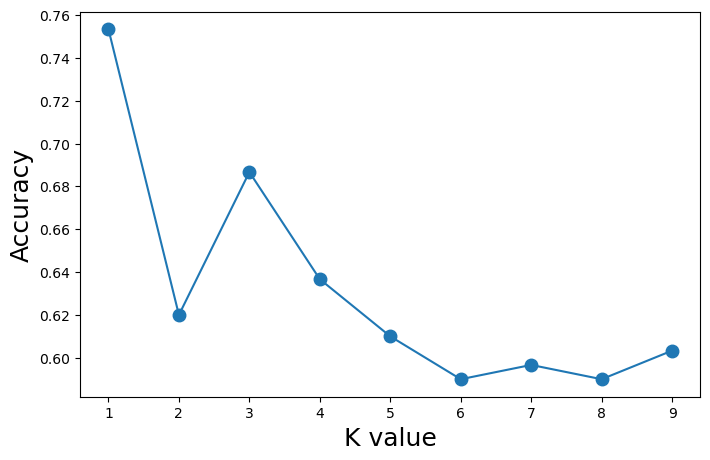

In [76]:
knn_acc = []

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    acc = cross_val_score(knn, sampled_X, sampled_Y, cv=5)
    knn_acc.append(acc.mean())

plt.figure(figsize=(8,5))
plt.plot(range(1,10),knn_acc, marker='o', markersize=9)
plt.xlabel("K value", fontsize=18)
plt.ylabel("Accuracy",fontsize=18)

- k=4 is optimal

#### Check the feature scaling method to KNN

In [77]:
knn = KNeighborsClassifier(n_neighbors=4)

In [78]:
acc = cross_val_score(knn, sampled_X, sampled_Y, cv=5)
print("Accuracy KNN without transformation: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))

/home/eng2018e102/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/eng2018e102/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

Accuracy KNN without transformation: 0.64 (+/- 0.10)


/home/eng2018e102/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [79]:
# create pipeline -> Standardization
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                   ('model',knn)])

# perform cross validation
acc = cross_val_score(estimator=pipeline, 
                         X=sampled_X, 
                         y=sampled_Y, 
                         cv=5
                        )

print("Accuracy KNN with Standardization: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))

/home/eng2018e102/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/eng2018e102/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

Accuracy KNN with Standardization: 0.69 (+/- 0.04)


/home/eng2018e102/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [80]:
# create pipeline - > Normalizaton
pipeline = Pipeline(steps=[('scaler', preprocessing.MinMaxScaler()),
                   ('model', knn)])

# perform cross validation
acc = cross_val_score(estimator=pipeline, 
                         X=sampled_X, 
                         y=sampled_Y, 
                         cv=5
                        )

print("Accuracy KNN with Normalizaton: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))

/home/eng2018e102/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/eng2018e102/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

Accuracy KNN with Normalizaton: 0.71 (+/- 0.03)


/home/eng2018e102/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


- Normalization performed well